In [217]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set()

In [218]:
import numpy as np
import h5py
from chainconsumer import ChainConsumer
from glob import glob
from os import path
from copy import deepcopy
from collections import OrderedDict

In [219]:
fnames = sorted(glob('/u/ki/swmclau2/des/PearceMCMC/HOD3_wp_ds_rmin_0.5_HOD.hdf5'))

Assume all chains run with same true values, only thing that differs is the rmin. 

In [220]:
fnames

['/u/ki/swmclau2/des/PearceMCMC/HOD3_wp_ds_rmin_0.5_HOD.hdf5']

In [221]:
_fnames = []
_fnames.extend(reversed(fnames[:-1]) )
_fnames.append(fnames[-1])
fnames = _fnames

In [222]:
fnames

['/u/ki/swmclau2/des/PearceMCMC/HOD3_wp_ds_rmin_0.5_HOD.hdf5']

In [223]:
model = path.basename(fnames[0]).split('_')[-1].split('.')[0]
#model = path.basename(fnames[0]).split('_')[-2]#.split('.')[0]

In [224]:
model

'HOD'

In [225]:
f = h5py.File(fnames[-1], 'r')

In [226]:
f.attrs.keys()

[u'chain_fixed_params',
 u'cov',
 u'dlogz',
 u'emu_cov_fname',
 u'emu_hps',
 u'emu_type',
 u'fixed_params',
 u'mcmc_type',
 u'nburn',
 u'nlive',
 u'nsteps',
 u'nwalkers',
 u'obs',
 u'param_names',
 u'seed',
 u'sim',
 u'training_file',
 u'true_cov_fname',
 u'true_data_fname']

In [227]:
n_walkers = f.attrs['nwalkers']

In [228]:
chain_pnames = f.attrs['param_names']

In [229]:
#sim_info = eval(f.attrs['sim'])
sim_info = f.attrs['sim']

In [230]:
#gal_type = eval(f.attrs['sim'])['gal_type']
gal_type = 'SHAM'

In [231]:
f.close()

In [232]:
chain_pnames

array(['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8', 'logM1',
       'logM0', 'sigma_logM', 'alpha', 'conc_gal_bias'], dtype='|S13')

In [233]:
param_name_dict = {'ombh2': r'$\Omega_b h^2$', 'omch2': r'$\Omega_c h^2$','w0': r'$w_0$','ns': r'$n_s$', \
                   'sigma8': r'$\sigma_8$', 'ln10As':r'$\ln 10^{10} A_s$', 'H0': r'$H_0$','Neff': r'$N_{eff}$',\
               'mean_occupation_centrals_assembias_corr1': r'$\rho_{cen}$',\
                 'mean_occupation_satellites_assembias_corr1':r'$\rho_{sat}$',\
                   'mean_occupation_centrals_assembias_param1': r'$\mathcal{A}_{cen}$',\
                 'mean_occupation_satellites_assembias_param1':r'$\mathcal{A}_{sat}$',\
                   'mean_occupation_centrals_assembias_slope1': r'$\mathcal{B}_{cen}$',\
                 'mean_occupation_satellites_assembias_slope1':r'$\mathcal{B}_{sat}$',\
                   'logM1': r'$\log(M_1)$','logM0': r'$\log(M_0)$','sigma_logM': r'$\sigma_{\log M }$',
                   'conc_gal_bias': r'$\eta$', 'alpha':r'$\alpha$' }

In [234]:
bounds_dict = {'H0': (61.69472, 74.76751999999999),
 'Neff': (2.62125, 4.27875),
 'alpha': (0.7, 1.3),
 'conc_gal_bias': (0.5, 2.0),
 'sigma8': (0.65, 1.0), # TODO update
 'logM0': (12.6, 13.6),
 'logM1': (13.7, 14.7),
 'ns': (0.9278462, 0.9974495999999999),
 'ombh2': (0.02066455, 0.02371239),
 'omch2': (0.1012181, 0.13177679999999997),
 'sigma_logM': (0.05, 0.5),
 'ln10As': (3.0, 3.1),
 'w0': (-1.399921, -0.5658486),
 'mean_occupation_centrals_assembias_corr1': (-1.0, 1.0),
 'mean_occupation_satellites_assembias_corr1': (-1.0, 1.0),
 'mean_occupation_centrals_assembias_param1': (-1.0, 1.0),
 'mean_occupation_satellites_assembias_param1': (-1.0, 1.0),
 'mean_occupation_centrals_assembias_slope1': (-3.0, 3.0),
 'mean_occupation_satellites_assembias_slope1': (-3.0, 3.0)}

In [235]:
hod_param_names = []
cosmo_param_names = []

hod_bounds = []
cosmo_bounds = []
cosmo_names = set(['ombh2', 'omch2', 'w0', 'ns', 'sigma8', 'H0', 'Neff', 'ln10As'])
for pname in chain_pnames:
    if pname in cosmo_names:
        cosmo_param_names.append(param_name_dict[pname])
        cosmo_bounds.append(bounds_dict[pname])
    else:
        hod_param_names.append(param_name_dict[pname])
        hod_bounds.append(bounds_dict[pname])
        
param_names = deepcopy(cosmo_param_names)
param_names.extend(hod_param_names)

bounds = deepcopy(cosmo_bounds)
bounds.extend(hod_bounds)

In [236]:
c = ChainConsumer()

In [237]:
n_burn = 2000

for fname in fnames:
#for fname in [fnames[0], fnames[3]]:
    try:
        f = h5py.File(fname, 'r')
        chain = f['chain'][n_burn*n_walkers:]
        chain = chain[np.all(chain!=0.0, axis = 1), :]
    except IOError:
        print 'Error loading', fname
        continue
    
    #print chain.shape
    chain = chain.reshape((-1, n_walkers, chain.shape[1]))
    #print chain.shape
    chain = chain.reshape((-1, chain.shape[2]), order = 'F')
    #chain = chain[:, 0, :]
    if chain.shape[0] == 0:
        print 'Insufficient samples in', fname
        continue
    
    #name = path.basename(fname).split('_')[-1].split('.')[0]
    name = path.basename(fname).split('_')[4]

    if name == "None":
        name = "0.1"
        
    name = r"$r_{min} = %s$"%name
    
    hod_param_names = []
    cosmo_param_names = []
    chain_pnames = f.attrs['param_names']
    cosmo_names = set(['ombh2', 'omch2', 'w0', 'ns', 'sigma8', 'H0', 'Neff'])
    for pname in chain_pnames:
        if pname in cosmo_names:
            cosmo_param_names.append(param_name_dict[pname])
        else:
            hod_param_names.append(param_name_dict[pname])

    param_names = deepcopy(cosmo_param_names)
    param_names.extend(hod_param_names)
    print fname
    print chain.shape, chain.shape[0]/n_walkers, len(param_names)
    c.add_chain(chain, parameters=param_names, name = name, walkers = n_walkers)
    f.close()

/u/ki/swmclau2/des/PearceMCMC/HOD3_wp_ds_rmin_0.5_HOD.hdf5
(679500, 12) 2718 12


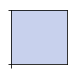

In [238]:
if model == 'HOD':
    #palette = sns.cubehelix_palette(len(fnames), start = 2.6, rot = 0.1, gamma = 0.7)
    palette = sns.cubehelix_palette(len(fnames), start = 2.6, rot = 0.1, gamma = 1.2)

elif model == 'HSAB':
    palette = sns.cubehelix_palette(len(fnames), start = 2.0, rot = 0.1, gamma = 0.7)
    #palette = sns.cubehelix_palette(len(fnames), start = 1.2, rot = 0.6, gamma = 1.7)
elif model == 'CAB':
    palette = sns.cubehelix_palette(len(fnames), start = 0.6, rot = 0.1, gamma = 1.2)
elif model == 'CorrAB':
    #palette = sns.cubehelix_palette(len(fnames), start = 1.2, rot = 0.1, gamma = 1.2)
    palette = sns.cubehelix_palette(len(fnames), start = 1.2, rot = 0.1, gamma = 2.0)

sns.palplot(palette)

In [239]:
def color_to_hex(color):
    return np.array(color)#*255

In [240]:
n_params = chain.shape[1] if len(chain.shape) > 1 else 1

In [241]:
hod_idxs = np.array(range(len(cosmo_param_names), len(cosmo_param_names)+len(hod_param_names)-1)) #skip eta
cosmo_idxs = np.array(range(len(cosmo_param_names)))

In [242]:
cosmo_param_names

['$\\Omega_b h^2$',
 '$\\Omega_c h^2$',
 '$w_0$',
 '$n_s$',
 '$H_0$',
 '$N_{eff}$',
 '$\\sigma_8$']

In [243]:
hod_param_names

['$\\log(M_1)$',
 '$\\log(M_0)$',
 '$\\sigma_{\\log M }$',
 '$\\alpha$',
 '$\\eta$']

In [244]:
if chain.shape[1] == 7:
    cosmo_chain = chain
    
elif chain.shape[1] == 5:
    hod_chain = chain
else:
    hod_chain = chain[:,hod_idxs]
    #cosmo_chain = chain[:,cosmo_idxs]

In [245]:
if gal_type == 'HOD':
    from pearce.mocks import cat_dict
    #cosmo_params = {'simname': sim_info['simname'], 'boxno': sim_info['sim_hps']['boxno'],\
    #                'realization': sim_info['sim_hps']['realization'], 'scale_factors':[sim_info['scale_factor']],\
    #                'system': 'ki-ls'}
    cosmo_params = {'simname': 'testbox', 'boxno': 1,\
                    'realization':0, 'scale_factors':[1.0],\
                    'system': 'ki-ls'}
    cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!
    
    cpv = cat._get_cosmo_param_names_vals()

    cat_val_dict =  {key: val for key, val in zip(cpv[0], cpv[1])}
    cosmo_true_vals = [cat_val_dict[pn] for pn in chain_pnames if pn in cat_val_dict]
    
    hod_params = {'alpha': 1.083, 'conc_gal_bias': 1.0, 'logM0': 13.2,'logM1': 14.2, 'sigma_logM': 0.2}#sim_info['hod_params']
    hod_true_vals = [hod_params[key] for key in chain_pnames if key in hod_params]
    
    if model!= 'HOD':
        hod_true_vals.extend([0, 0])
        if model == 'CAB':
            hod_true_vals.extend([0,0])
else: #SHAM, etc on MDPL2
 
    # multidark planck2
    #cosmo_true_vals = np.array([0.0223, 0.1188, -1, 0.9667, 3.047, \
    #                            0.6774*100, 3.046]) #darksky
    
    h = 0.6777
    #cosmo_pnames = ['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8']
    cosmo_true_vals = np.array([0.048206*h**2, 0.307115*h**2- 0.048206*h**2,\
                                -1, 0.9667, \
                                h*100, 3.046, 0.8228]) #mdpl2

    hod_true_vals = np.array([np.inf for p in hod_param_names])

In [246]:
hod_param_names

['$\\log(M_1)$',
 '$\\log(M_0)$',
 '$\\sigma_{\\log M }$',
 '$\\alpha$',
 '$\\eta$']

In [247]:
# Enforce a consistent order for the plots
#if gal_type == 'HOD':
    
plot_hod_param_names = ['$\\sigma_{\\log M }$', '$\\log(M_0)$', '$\\log(M_1)$', '$\\alpha$', '$\\eta$']
plot_hod_true_vals = [0.2, 13.2, 14.2, 1.083, 1.0]

plot_hod_bounds = [(0.05, 0.5), (12.6, 13.6), (13.7, 14.7), (0.7, 1.3), (0.5, 2.0)]

ab_param_names = [r'$\mathcal{A}_{%s}$', r'$\mathcal{B}_{%s}$', r'$\rho_{%s}$']
ab_true_vals = [0.0, np.inf,0.0]
for abpn, hodtv in zip(ab_param_names, ab_true_vals):
    if abpn%'cen' in hod_param_names: # this pname is in the model
        if 'B' in abpn:
            plot_hod_true_vals.extend([np.inf, np.inf])
            plot_hod_param_names.extend([abpn%'cen', abpn%'sat'])

            continue
        for gal_type in ['cen', 'sat']:
            plot_hod_param_names.append(abpn%gal_type)#

            if gal_type == 'cen':
                plot_hod_true_vals.append(1.0)
            else:
                plot_hod_true_vals.append(-1.0)

            plot_hod_bounds.append((-1.0, 1.0))

#for phpn in plot_hod_param_names:
#    i = hod_param_names.index(phpn)
#    print phpn, i, hod_true_vals[i]
#    plot_hod_true_vals.append(hod_true_vals[i])
#    plot_hod_bounds.append(hod_bounds[i])


In [248]:
plot_hod_true_vals

[0.2, 13.2, 14.2, 1.083, 1.0]

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


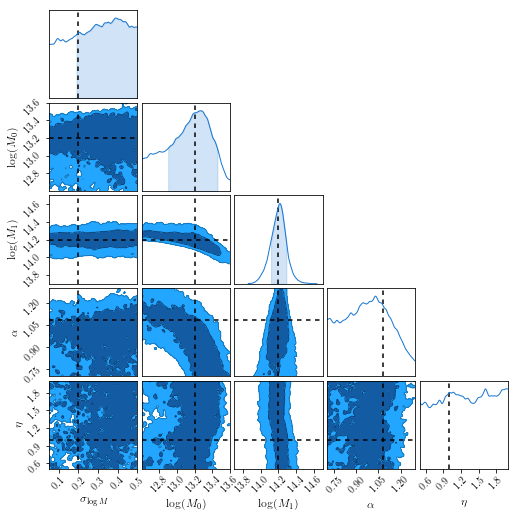

In [249]:
fig = c.plotter.plot(figsize='GROW',parameters = plot_hod_param_names, truth=plot_hod_true_vals, extents=plot_hod_bounds) 
#plt.suptitle('HSAB')
fig.show()

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


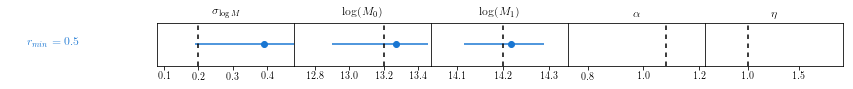

In [250]:
fig = c.plotter.plot_summary(parameters = plot_hod_param_names, 
                             truth=plot_hod_true_vals,\
                             figsize=2, errorbar=True) 
#fig.suptitle(model) # + galtype
fig.show()

In [251]:
cosmo_true_vals

array([ 2.21399210e-02,  1.18911024e-01, -1.00000000e+00,  9.66700000e-01,
        6.77700000e+01,  3.04600000e+00,  8.22800000e-01])

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


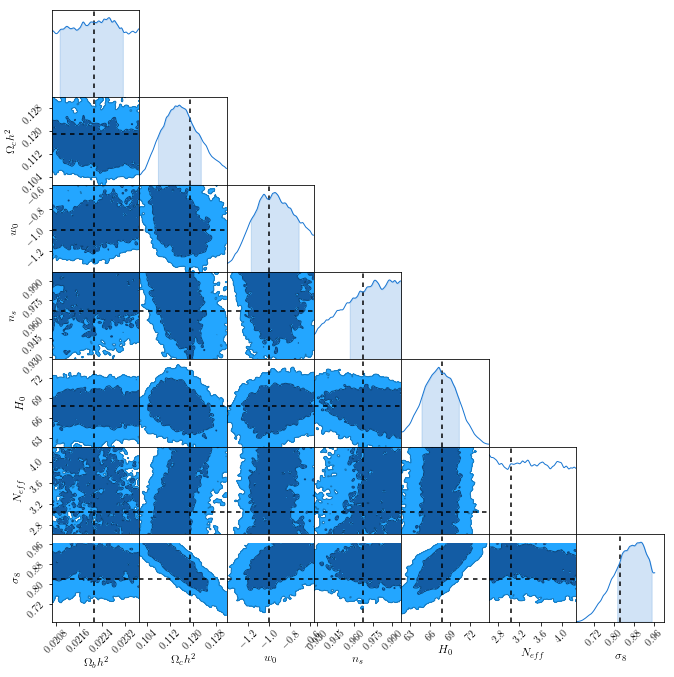

In [252]:
fig = c.plotter.plot(figsize='PAGE', parameters = cosmo_param_names, truth=cosmo_true_vals, extents=cosmo_bounds) 
fig.show()

In [253]:
from copy import deepcopy
true_vals  = list(deepcopy(cosmo_true_vals))
true_vals.extend(plot_hod_true_vals)

In [254]:
plot_param_names = list(deepcopy(cosmo_param_names))
plot_param_names.extend(plot_hod_param_names)

In [255]:
plot_param_bounds = list(deepcopy(cosmo_bounds))
plot_param_bounds.extend(plot_hod_bounds)

In [256]:
len(plot_param_names)

12

In [257]:
# TODO can choose these by galaxy model 
# TODO combine multiple chains? 
#summary_idxs = [1, 4]
summary_idxs = [1, 4,6]
if len(plot_param_names) > 12:
    summary_idxs.extend([12,13])
    #summary_idxs.extend([11,12])


summary_pnames = [plot_param_names[i] for i in summary_idxs]
summary_truths = [true_vals[i] for i in summary_idxs]
summary_bounds = [plot_param_bounds[i] for i in summary_idxs]

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


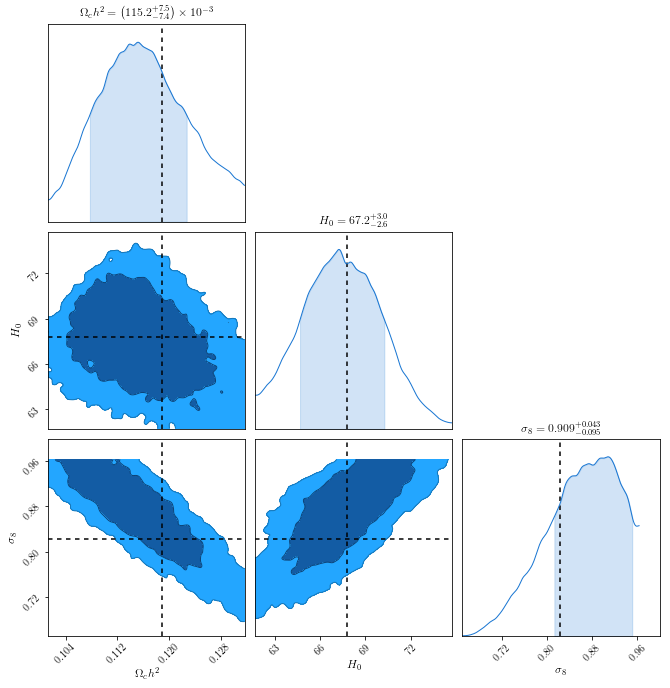

In [258]:
fig = c.plotter.plot(figsize='PAGE', parameters =summary_pnames\
                                    , truth=summary_truths, extents=summary_bounds) 
fig.show()

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


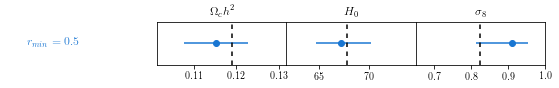

In [259]:
fig = c.plotter.plot_summary(parameters = summary_pnames, truth=summary_truths, extents=summary_bounds,\
                             figsize=2, errorbar=True) 
#fig.suptitle(model) # + galtype
fig.show()